In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hepth-dataset/CA-HepTh.txt
/kaggle/input/enron-dataset/Email-Enron.txt
/kaggle/input/facebook-dataset/fb_sam.txt


In [3]:
import networkx as nx

# Load the graph from a text file in the edge list format
graph = nx.read_edgelist('/kaggle/input/facebook-dataset/fb_sam.txt')

# Print the number of nodes and edges in the graph
print("Number of Nodes:", graph.number_of_nodes())
print("Number of Edges:", graph.number_of_edges())

Number of Nodes: 4039
Number of Edges: 88234


In [4]:
import numpy as np

matrix = nx.to_numpy_matrix(graph)

# Check for NaNs or missing values in the NumPy array
inds = np.where(np.isnan(matrix))

# Identify the nodes and edges with missing values
nodes_with_missing_values = set(inds[0])
edges_with_missing_values = set(zip(inds[0], inds[1]))

# Remove the nodes and edges with missing values
graph.remove_nodes_from(nodes_with_missing_values)
graph.remove_edges_from(edges_with_missing_values)

# Print the updated number of nodes and edges in the graph
print("Number of Nodes:", graph.number_of_nodes())
print("Number of Edges:", graph.number_of_edges())

Number of Nodes: 4039
Number of Edges: 88234


In [5]:
bc = list(nx.betweenness_centrality(graph).values())

In [6]:
import math

# Compute degree-based entropy for each node
degree_seq = sorted([d for n, d in graph.degree()], reverse=True)
max_degree = max(degree_seq)
degree_probs = [float(d)/max_degree for d in degree_seq]
degree_entropy_dict = {}
for node in graph.nodes():
    degree = graph.degree(node)
    degree_prob = float(degree)/max_degree
    degree_entropy = -degree_prob * math.log(degree_prob, 2)
    degree_entropy_dict[node] = degree_entropy

dg = list(degree_entropy_dict.values())
lc = list(nx.clustering(graph).values())

In [7]:
import numpy as np
import networkx as nx

def similarity(xi, xj, sigma):
    """
    Compute the similarity between node i and node j
    based on the given formula.
    """
    distance = np.linalg.norm(xi - xj)
    return np.exp(-distance**2 / (2 * sigma**2))

def construct_similarity_graph(G, K):
    """
    Construct a similarity graph based on the given node features.
    """
    n = G.number_of_nodes()
    nodes = np.zeros((n, 3))  # create a numpy array to store the node features
    for i in range(n):
        nodes[i] = np.array([bc[i], dg[i], lc[i]])
    # Compute the parameter sigma as the average number of shortest paths between all pairs of nodes
    path_lengths = dict(nx.shortest_path_length(G))
    sigma = np.mean([path_lengths[u][v] for u in G.nodes() for v in G.nodes() if u != v and u in path_lengths and v in path_lengths[u]])

    gs = nx.Graph()
    for i in range(n):
        for j in range(n):
            sim = similarity(nodes[i], nodes[j], sigma)
            gs.add_edge(i, j, weight=sim)
    for i in range(n):
        # Get the K nearest neighbors of node i
        neighbors = sorted(gs.edges(i, data=True), key=lambda x: x[2]['weight'], reverse=True)[:K]
        # Add edges between node i and its neighbors
        for neighbor in neighbors:
            gs.add_edge(i, neighbor[1], weight=neighbor[2]['weight'])
    return gs



In [8]:
# Construct the similarity graph with K=3

gs = construct_similarity_graph(graph, K=3)

# Print the number of nodes and edges in the similarity graph
print(f"Number of nodes: {gs.number_of_nodes()}")
print(f"Number of edges: {gs.number_of_edges()}")


Number of nodes: 4039
Number of edges: 8158780


In [9]:
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigs

def spectral_clustering(G, k, T):
    n = len(G.nodes())
    A = nx.adjacency_matrix(G)
    D = np.diag(np.ravel(np.sum(A, axis=1)))
    L = D - A
    vals, vecs = eigs(L.astype(float), k=k, which='SM')
    kmeans = KMeans(n_clusters=T, random_state=0).fit(vecs.real)
    clusters = kmeans.labels_
    subgraphs = [[] for _ in range(T)]
    for i in range(n):
        subgraphs[clusters[i]].append(i)
    return subgraphs

def ratiocut_spectral_clustering(G, k):
    n = len(G.nodes())
    T = int(n / k)
    if T < (n / (2 * k)) - 1:
        T = int(n / (2 * k)) - 1
    subgraphs = spectral_clustering(G, k, T)
    return subgraphs

In [10]:
T_subgraphs = ratiocut_spectral_clustering(graph, 3)

In [11]:
len(T_subgraphs)

1346

In [12]:
import networkx as nx

# function to calculate cost of matching two nodes
def matching_cost(G1, G2):
    # create bipartite graph
    B = nx.Graph()
    for u in G1.nodes():
        for v in G2.nodes():
            B.add_edge(u, v, weight=-abs(G1.degree(u) - G2.degree(v)))

    # add dummy nodes to balance graph
    n1, n2 = len(G1.nodes()), len(G2.nodes())
    if n1 > n2:
        B.add_nodes_from(range(n2, n1), bipartite=1)
    elif n2 > n1:
        B.add_nodes_from(range(n1, n2), bipartite=0)

    # calculate maximum weight bipartite matching
    matching = nx.algorithms.bipartite.matching.minimum_weight_full_matching(B)

    # calculate cost
    cost = 0
    for u, v in matching.items():
        cost += -B[u][v]['weight']
    cost += len(matching) * abs(G1.degree()[0] - G2.degree()[0])

    return cost

# function to modify 1-neighborhood graphs to be isomorphic
def modify_graphs(G, clusters):
    # find seed node in each cluster
    seed_nodes = []
    for i in range(len(clusters)):
        min_cost = float('inf')
        seed_node = None
        for j in range(len(clusters[i])):
            cost = 0
            for k in range(len(clusters[i])):
                if k != j:
                    if clusters[i][j] in G and clusters[i][k] in G:  # check if nodes are present in G
                        cost += matching_cost(G.subgraph(G.neighbors(clusters[i][j])), 
                                              G.subgraph(G.neighbors(clusters[i][k])))
            if cost < min_cost:
                min_cost = cost
                seed_node = clusters[i][j]
        seed_nodes.append(seed_node)

    # modify 1-neighborhood graphs to be isomorphic
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if clusters[i][j] != seed_nodes[i] and clusters[i][j] in G.nodes() and seed_nodes[i] in G.nodes():
                cost = matching_cost(G.subgraph(G.neighbors(clusters[i][j])), 
                                     G.subgraph(G.neighbors(seed_nodes[i])))
                nodes_to_add = len(G.subgraph(G.neighbors(seed_nodes[i])).nodes()) - \
                               len(G.subgraph(G.neighbors(clusters[i][j])).nodes())
                for k in range(nodes_to_add):
                    G.add_node(len(G.nodes()), label='dummy')
                G_sub = G.subgraph(G.neighbors(clusters[i][j])).copy()
                for u in G_sub.nodes():
                    for v in G.subgraph(G.neighbors(seed_nodes[i])).nodes():
                        G.add_edge(u, v, weight=-abs(G_sub.degree(u) - G.degree(v)))
                matching = nx.algorithms.bipartite.matching.minimum_weight_full_matching(G.subgraph(G.neighbors(clusters[i][j]) + 
                                                                                                 G.neighbors(seed_nodes[i])))
                for u, v in matching.items():
                    if (u in G_sub.nodes()) and (v not in G.subgraph(G.neighbors(clusters[i][j])).nodes()):
                        G.remove_node(v)
                    elif (v in G.subgraph(G.neighbors(seed_nodes[i])).nodes()) and (u not in G_sub.nodes()):
                        G.remove_node(u)

    return G


In [13]:
ananomised_graph = modify_graphs(graph, T_subgraphs)

In [14]:
print("Number of Nodes:", ananomised_graph.number_of_nodes())
print("Number of Edges:", ananomised_graph.number_of_edges())

Number of Nodes: 4039
Number of Edges: 88234


In [15]:
# Find the average degree of the graph
avg_degree = sum(dict(ananomised_graph.degree()).values()) / len(ananomised_graph.nodes())
print('Average degree:', avg_degree)

# Find the average shortest path length of the graph
avg_shortest_path_length = nx.average_shortest_path_length(ananomised_graph)
print('Average shortest path length:', avg_shortest_path_length)

# Find the average clustering coefficient of the graph
avg_clustering_coefficient = nx.average_clustering(ananomised_graph)
print('Average clustering coefficient:', avg_clustering_coefficient)

Average degree: 43.69101262688784
Average shortest path length: 3.6925068496963913
Average clustering coefficient: 0.6055467186200876


In [16]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_neighborhood_graphs(G, nodes):
    plt.figure(figsize=(10, 10))
    for i, node in enumerate(nodes):
        plt.subplot(3, 3, i+1)
        node_list = [node] + list(G.neighbors(node))
        subgraph = G.subgraph(node_list)
        pos = nx.spring_layout(subgraph)
        nx.draw(subgraph, pos, with_labels=True)
        plt.title(f"Node {node}")
    plt.tight_layout()
    plt.show()


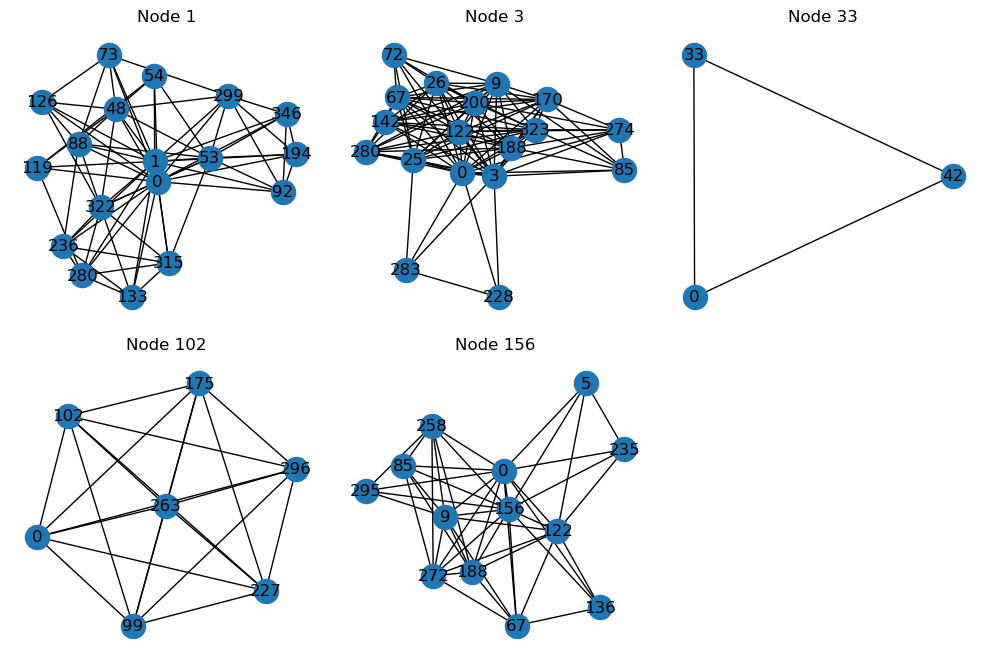

In [17]:
plot_neighborhood_graphs(ananomised_graph, ['1','3','33','102','156'])
